# Topic Modeling

In machine learning and natural language processing, a topic model is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body. Intuitively, given that a document is about a particular topic, one would expect particular words to appear in the document more or less frequently: "dog" and "bone" will appear more often in documents about dogs, "cat" and "meow" will appear in documents about cats, and "the" and "is" will appear approximately equally in both.

Topic modeling is a technique of extracting hidden topics from a volume of text. Topic modeling is a classic solution to the problem of information retrieval using linked data and semantic web technology. Related models and techniques are, among others, latent semantic indexing, independent component analysis, probabilistic latent semantic indexing, non-negative matrix factorization, Gamma-Poisson distribution and Latent Derichlet Allocation (LDA). Source: <a href='https://en.wikipedia.org/wiki/Topic_model'>wikipedia</a>

### Import required libraries

In [1]:
# !pip install pyLDAvis # Uncomment and install this visualization library

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Data manipulation
import pandas as pd
import numpy as np
from pprint import pprint

# Data preprocessing & cleaning
import re
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

# Modeling
import gensim

# Model Evaluation
from gensim.models import CoherenceModel

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim 

In [4]:
plt.style.use('ggplot')

### Load dataset

We will use 20-Newsgroups dataset. The dataset contains around 11k newsgroups posts from 20 different topics. The dataset is found here <a href='https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json'>newsgroups</a>

In [5]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')

Check firt 5 rows 

In [6]:
df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


Check rows and columns

In [7]:
df.shape

(11314, 3)

### Preprocess Data

Remove emails

In [8]:
data = df.content.values.tolist() # Convert to list first

In [9]:
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data] #Remove email addresses

<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:1: DeprecationWarning: invalid escape sequence \S
<ipython-input-9-0ada1bb0dac8>:1: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data] #Remove email addresses


Remove new line characters

In [10]:
data = [re.sub('\s+', ' ', sent) for sent in data]

<input>:1: DeprecationWarning: invalid escape sequence \s
<input>:1: DeprecationWarning: invalid escape sequence \s
<input>:1: DeprecationWarning: invalid escape sequence \s
<ipython-input-10-e591ccbe0189>:1: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


Remove distracting single quotes

In [11]:
data = [re.sub("\'", "", sent) for sent in data]

Tokenize the text

In [12]:
def tokenize_to_words(text):
    for t in text:
        yield(gensim.utils.simple_preprocess(str(t), deacc=True))  # deacc=True removes punctuations

In [13]:
tokenized_data = list(tokenize_to_words(data))

Remove stopwords

In [14]:
def remove_stopwords(text):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords.words('english')] for doc in text]

In [15]:
tokenized_data=remove_stopwords(tokenized_data)

### Create Data Input to Model

1. Create Dictionary

In [16]:
id2word = corpora.Dictionary(tokenized_data)

2. Create Corpus (Term Document Frequency)

In [17]:
corpus = [id2word.doc2bow(text) for text in tokenized_data]

Show corpus and frequency

In [18]:
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[('addition', 1), ('anyone', 2), ('body', 1), ('bricklin', 1), ('brought', 1), ('bumper', 1), ('called', 1), ('car', 5), ('college', 1), ('could', 1), ('day', 1), ('door', 1), ('doors', 1), ('early', 1), ('edu', 1), ('engine', 1), ('enlighten', 1), ('front', 1), ('funky', 1), ('history', 1), ('host', 1), ('il', 1), ('info', 1), ('know', 1), ('late', 1), ('lerxst', 1), ('lines', 1), ('looked', 1), ('looking', 1), ('made', 1), ('mail', 1), ('maryland', 1), ('model', 1), ('name', 1), ('neighborhood', 1), ('nntp', 1), ('organization', 1), ('park', 1), ('please', 1), ('posting', 1), ('production', 1), ('rac', 1), ('really', 1), ('rest', 1), ('saw', 1), ('separate', 1), ('small', 1), ('specs', 1), ('sports', 1), ('subject', 1), ('tellme', 1), ('thanks', 1), ('thing', 1), ('umd', 1), ('university', 1), ('wam', 1), ('whatever', 1), ('wheres', 1), ('wondering', 1), ('years', 1)]]


### Modeling LDA Topic model

#### Latent Dirichlet allocation (LDA)

Latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. LDA is an example of a topic model and belongs to the machine learning toolbox and in wider sense to the artificial intelligence toolbox. Source: <a href='https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation'>wikipedia</a>

In the LDA model below we specify chunksize which is the number of document to use for each training iteration/chunk. passes is the total number of training pass.

In [63]:
model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=6, random_state=100, update_every=1,
                                           chunksize=100,passes=10,alpha='auto',per_word_topics=True)

Show topics

Each keyword has a weighted importance value

In [64]:
pprint(model.print_topics())

[(0,
  '0.008*"people" + 0.007*"israel" + 0.006*"said" + 0.006*"armenian" + '
  '0.005*"armenians" + 0.005*"jews" + 0.005*"israeli" + 0.005*"turkish" + '
  '0.004*"war" + 0.004*"children"'),
 (1,
  '0.009*"subject" + 0.009*"lines" + 0.008*"organization" + 0.007*"use" + '
  '0.006*"space" + 0.005*"system" + 0.005*"thanks" + 0.004*"windows" + '
  '0.004*"posting" + 0.004*"host"'),
 (2,
  '0.010*"would" + 0.008*"one" + 0.008*"jesus" + 0.008*"people" + 0.008*"god" '
  '+ 0.005*"life" + 0.005*"believe" + 0.005*"dont" + 0.005*"say" + '
  '0.004*"think"'),
 (3,
  '0.016*"stephanopoulos" + 0.015*"mr" + 0.014*"government" + '
  '0.011*"president" + 0.010*"law" + 0.009*"key" + 0.009*"gun" + '
  '0.008*"public" + 0.007*"encryption" + 0.007*"use"'),
 (4,
  '0.010*"lines" + 0.010*"organization" + 0.010*"subject" + 0.009*"writes" + '
  '0.009*"article" + 0.008*"would" + 0.007*"one" + 0.006*"dont" + 0.006*"like" '
  '+ 0.006*"university"'),
 (5,
  '0.648*"ax" + 0.047*"max" + 0.005*"pl" + 0.004*"scsi"

### Model Evaluation

1. Model perplexity

In information theory, perplexity is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample. <a href='https://en.wikipedia.org/wiki/Perplexity'>wikipedia</a>

In [65]:
model.log_perplexity(corpus)

-8.875629045421265

2. Topic Coherence 

Topic coherence is a metric that returns the coherene score with is a measure of the degree of semantic similarity between high scoring words in the topic

In [66]:
model_coherence = CoherenceModel(model=model, texts=tokenized_data, dictionary=id2word, coherence='c_v')

In [67]:
model_coherence.get_coherence()

0.6057196929904957

### Visualize the topics

In [68]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(model, corpus, id2word)

In [69]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.212602  0.086814       1        1  39.756340
1     -0.138816  0.159283       2        1  25.166203
2     -0.167879  0.002106       3        1  16.316360
0      0.024394 -0.223274       4        1   7.756248
5      0.373873  0.195318       5        1   5.854996
3      0.121029 -0.220246       6        1   5.149842, topic_info=      Category          Freq            Term         Total  loglift  logprob
term                                                                        
5085   Default  69453.000000              ax  69453.000000  30.0000  30.0000
4573   Default   5041.000000             max   5041.000000  29.0000  29.0000
487    Default   4978.000000          people   4978.000000  28.0000  28.0000
2714   Default   2363.000000              mr   2363.000000  27.0000  27.0000
376    Default   5083.000000             use   5083.000000  26.0000  26.0000
61371  Default   1519.000000  stephanopoulos   1519.000000  25.0000  25.0000
1222   Default   2423.000000           jesus   2423.000000  24.0000  24.0000
179    Default   9530.000000           would   9530.000000  23.0000  23.0000
384    Default   7665.000000          writes   7665.000000  22.0000  22.0000
541    Default   2368.000000             god   2368.000000  21.0000  21.0000
1657   Default   1676.000000      government   1676.000000  20.0000  20.0000
900    Default   1850.000000             law   1850.000000  19.0000  19.0000
2333   Default   2592.000000           space   2592.000000  18.0000  18.0000
495    Default   2682.000000            said   2682.000000  17.0000  17.0000
898    Default   1284.000000             key   1284.000000  16.0000  16.0000
256    Default   6256.000000            dont   6256.000000  15.0000  15.0000
26     Default  12158.000000           lines  12158.000000  14.0000  14.0000
1039   Default   4207.000000           think   4207.000000  13.0000  13.0000
1375   Default   1041.000000       president   1041.000000  12.0000  12.0000
49     Default  12667.000000         subject  12667.000000  11.0000  11.0000
36     Default  11557.000000    organization  11557.000000  10.0000  10.0000
2939   Default   2221.000000     information   2221.000000   9.0000   9.0000
728    Default   1240.000000          public   1240.000000   8.0000   8.0000
238    Default   2755.000000          system   2755.000000   7.0000   7.0000
64     Default   7282.000000         article   7282.000000   6.0000   6.0000
333    Default   1887.000000            life   1887.000000   5.0000   5.0000
247    Default   1991.000000         windows   1991.000000   4.0000   4.0000
1160   Default   2122.000000         believe   2122.000000   3.0000   3.0000
564    Default   9192.000000             one   9192.000000   2.0000   2.0000
2678   Default    848.000000             gun    848.000000   1.0000   1.0000
...        ...           ...             ...           ...      ...      ...
6929    Topic6    111.742172   conversations    112.632080   2.9583  -6.7376
28492   Topic6    138.434540      estimating    139.537384   2.9583  -6.5234
2735    Topic6    357.042816         protect    366.146301   2.9410  -5.5760
1375    Topic6    994.608337       president   1041.526489   2.9201  -4.5515
1052    Topic6    363.322235           crime    381.041046   2.9186  -5.5585
2758    Topic6    401.657532        security    427.249329   2.9044  -5.4582
1588    Topic6    257.231171        congress    270.401978   2.9163  -5.9038
1657    Topic6   1321.373779      government   1676.986450   2.7279  -4.2674
3946    Topic6    501.372040          police    594.786316   2.7954  -5.2365
1059    Topic6    541.452454          health    671.671936   2.7507  -5.1596
903     Topic6    314.523071           legal    357.418793   2.8384  -5.7028
3557    Topic6    287.155273           court    321.394989   2.8536  -5.7938
1438    Topic6    311.115082            drug    354.959747  

### Interpreting the Visual

Each bubble on the left graph represents a topic. The larger the bubble, the more prevalent is that topic. A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant. A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

### Model Tuning

Getting most optimal number of topics

In [26]:
limit=50; 
start=1; 
step=6;

In [31]:
def compute_optimal_topics(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [33]:
model_list, coherence_values = compute_optimal_topics(dictionary=id2word, corpus=corpus, texts=tokenized_data, start=start, limit=limit, step=step)

Vsualize

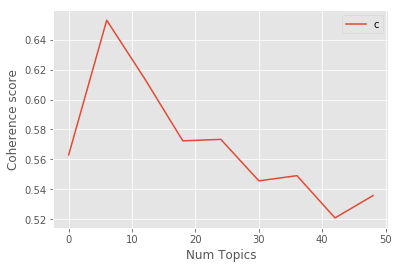

In [34]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Show topics and coherence values

In [35]:
for m, cv in zip(x, coherence_values):
   print("Num Topics =", m, " is having Coherence Value of", round(cv, 4))

Num Topics = 0  is having Coherence Value of 0.563
Num Topics = 6  is having Coherence Value of 0.653
Num Topics = 12  is having Coherence Value of 0.6139
Num Topics = 18  is having Coherence Value of 0.5724
Num Topics = 24  is having Coherence Value of 0.5734
Num Topics = 30  is having Coherence Value of 0.5456
Num Topics = 36  is having Coherence Value of 0.5491
Num Topics = 42  is having Coherence Value of 0.5209
Num Topics = 48  is having Coherence Value of 0.5358


### Other Topic Modeling Algorithms Implemented in gensim

#### 1. LDA Mallet Model

MAchine Learning for LanguagE Toolkit (MALLET) is an open source toolkit developed by Andrew McCullum. It is a Java based package which is used for NLP tasks such as document classification, clustering, topic modeling e.t.c. Mallet provides Topic Modeling capabilities which contains an efficient, sampling-based implementations of LDA as well as Hierarchical LDA.

To use MALLET we must download it from here<a href='http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip'>mallet</a> and unzip it in a local directory.

Locate the Mallet file

In [57]:
# import os
# os.environ.update({'MALLET_HOME':r'C:/mallet/mallet-2.0.8/'})

In [58]:
# mallet_path = 'C:/mallet/mallet-2.0.8/bin/mallet' # update this path to where you have unzipped your mallet file
# mallet_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

CalledProcessError: Command 'C:/mallet/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\soongaya\AppData\Local\Temp\2e0ca1_corpus.txt --output C:\Users\soongaya\AppData\Local\Temp\2e0ca1_corpus.mallet' returned non-zero exit status 1.

In [ ]:
# Compute Coherence Score
coherence_mallet_model = CoherenceModel(model=mallet_model, texts=tokenized_data, dictionary=id2word, coherence='c_v')
coherence_mallet_model.get_coherence()

#### 2. Hierarchical Dirichlet Process (HPD) Model

hierarchical Dirichlet process (HDP) is a nonparametric Bayesian approach to clustering grouped data.[1][2] It uses a Dirichlet process for each group of data, with the Dirichlet processes for all groups sharing a base distribution which is itself drawn from a Dirichlet process. This method allows groups to share statistical strength via sharing of clusters across groups. The base distribution being drawn from a Dirichlet process is important, because draws from a Dirichlet process are atomic probability measures, and the atoms will appear in all group-level Dirichlet processes <a href='https://en.wikipedia.org/wiki/Hierarchical_Dirichlet_process'>wikipedia</a>.

HDP is an extension of LDA model and is designed to handle where the number of mixture components (the number of "topics" in document-modeling terms) is not known.In HPD maximum number of topics can be unbounded and learned from the data rather than specified in advance.

Modeling with HDP

In [59]:
hdp_model = gensim.models.hdpmodel.HdpModel(corpus=corpus, id2word=id2word)

In [60]:
# Compute Coherence Score
coherence_hdp_model = CoherenceModel(model=hdp_model, texts=tokenized_data, dictionary=id2word, coherence='c_v')
coherence_hdp_model.get_coherence()

0.4989710407164633

#### 3. Latent Semantic Indexing (LSI)

Latent semantic indexing (LSI) is an indexing and retrieval method that uses a mathematical technique called singular value decomposition (SVD) to identify patterns in the relationships between the terms and concepts contained in an unstructured collection of text. LSI is based on the principle that words that are used in the same contexts tend to have similar meanings. A key feature of LSI is its ability to extract the conceptual content of a body of text by establishing associations between those terms that occur in similar contexts. source:<a href='https://en.wikipedia.org/wiki/Latent_semantic_analysis#LSI_timeline'>wikipedia</a>

Modeling with LSI

In [61]:
lsi_model = gensim.models.lsimodel.LsiModel(corpus=corpus, id2word=id2word, num_topics=6,chunksize=100)

In [62]:
# Compute Coherence Score
coherence_lsi_model = CoherenceModel(model=lsi_model, texts=tokenized_data, dictionary=id2word, coherence='c_v')
coherence_lsi_model.get_coherence()

0.6893703163669846

### Conclusion

How to improve the model:<hr>
1. Improve on text processing.
2. The variety of topics the text talks about.
3. Topic modeling algorithm to use.
4. The number of topics to be retrieved from the algorithm.
5. The Model hyperparameter tuning.